## DB PROJECT

This project is non-profit, personal project for education purposes only.

1) scrape comics db data - save them into file (huge amount of data scraped from nonprofit db - save it to the csv and avoid another round of scraping)
2) do some basic data exploration
3) create sqlite3 db (separate comics.sql script)
4) import data from scraped .csv files
5) connect a python command line tool to the db and allow users to search the db

Thanks to the people from https://www.comicsdb.cz/ project.

### Importing all the neccessary libraries for scraping

In [4]:
import csv
import re
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

DRIVER_PATH = "C:\\Users\\petr.musil\\Desktop\\python\\edgedriver\\msedgedriver.exe"
service = Service(executable_path = DRIVER_PATH)

### Data collection - download all of the publishers links from the comicsdb.cz and export them to a .csv file

In [5]:
try:
    driver = webdriver.Edge(service=service)
    publisher = "https://www.comicsdb.cz/prehled-nakladatelstvi/1/"
    list_of_links = []
    for num in list(range(1,8)):
        driver.get(f'{publisher}{num}')    
        time.sleep(1)
        # wait for the element
        element = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, ".card.text-center.p-2")))
        links = driver.find_element(by = By.CSS_SELECTOR, value = ".table-border-dashed").find_elements(by = By.TAG_NAME, value = "a")
        for link in links:
            list_of_links.append([link.get_attribute("href")])
finally:
    driver.quit()

filename = "./data/links_publishers.csv"
with open(filename, "w", newline="") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(list_of_links)

### Visit each webpage of a publisher from the source .csv file and get name, number of titles and link. Save the result to a .csv file

In [29]:
try:
    list_of_publisher_data = []
    with open("./data/links_publishers.csv", "r") as file:
        reader = csv.reader(file)
        for row in reader:
            driver.get(row[0])
            time.sleep(1)
            publisher = WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, ".font-weight-semibold")))
            number_of_titles = WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, ".font-weight-bold.text-cdbred.ml-1")))
            list_of_publisher_data.append([publisher.text.strip(), number_of_titles.text.strip(), row[0].strip()])
finally:
    driver.quit()

filename = "./data/output_publishers_data.csv"
with open(filename, "w", newline="", encoding="utf-8") as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=";")
    csvwriter.writerow(["name", "number_of_titles", "link"])
    csvwriter.writerows(list_of_publisher_data)

### Visit all titles overviews and save links to all the titles to a .csv file

In [39]:
try:
    overview = "https://www.comicsdb.cz/prehled-comicsu/6/"
    list_of_links = []
    for num in list(range(1,106)):
        driver.get(f'{overview}{num}')    
        time.sleep(2)
        # wait for the element
        table_ = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, ".table.table-hover.table-xs")))
        links = driver.find_elements(by = By.CSS_SELECTOR, value = ".table-border-dashed a")
        #links = links.find_elements(by = By.TAG_NAME, value = "a")
        for link in links:
            list_of_links.append([link.get_attribute("href")])
finally:
    driver.quit()

filename = "./data/links_titles.csv"
with open(filename, "w", newline="", encoding="utf-8") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(list_of_links)

### Visit all the titles details and get all the data

In [7]:
try:
    list_of_titles_data = []
    with open("./data/links_titles.csv", "r") as file:
        reader = csv.reader(file)
        for row in reader:
            driver.get(row[0])
            time.sleep(2)
            title = WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, ".font-weight-semibold")))
            soup = BeautifulSoup(driver.page_source, "html.parser")
            title = soup.find("span", "font-weight-semibold").text
            basic_info = soup.find("small")
            try:
                link_publisher = basic_info.find("a").get("href")
            except:
                link_publisher = "NA"
            try:
                year_pattern = re.compile(r'\d{4}')
                year = year_pattern.search(basic_info.text)
                year = year.group()
            except:            
                year = "NA"
            pages = "NA"
            price = "NA"
            dt_tags = soup.find_all("dt")
            for tag in dt_tags:
                if "Stran" in tag.text:
                    pages = tag.next_sibling.text
                elif "Cena" in tag.text:
                    price = tag.next_sibling.text
            list_of_titles_data.append([title.strip(), year.strip(), row[0].strip(), link_publisher.strip(), pages.strip(), price.strip()])
finally:
    driver.quit()

filename = "./data/output_titles_data.csv"
with open(filename, "w", newline="", encoding="utf-8") as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=";")
    csvwriter.writerow(["title", "year", "link_title","link_publisher", "pages", "price"])
    csvwriter.writerows(list_of_titles_data)
    

### Explore the gathered data

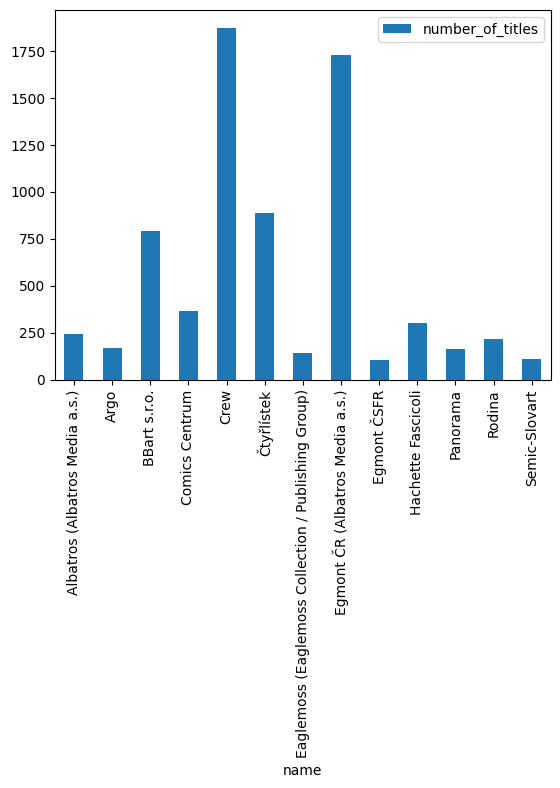

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

publishers = pd.read_csv("./data/output_publishers_data.csv", delimiter=";")
publishers = publishers[publishers["number_of_titles"] > 100]
publishers.plot(kind = "bar", x = "name", y = "number_of_titles")
plt.show()

In [13]:
titles = pd.read_csv("./data/output_titles.csv", delimiter=";")
titles_origin = titles.copy()
titles = titles[titles["link_publisher"] == "/nakladatelstvi/1/crew"]
titles["year"] = titles["year"].astype(int)
mean_pages = titles["pages"].mean()
titles["pages"] = titles["pages"].fillna(mean_pages).astype(int)
titles["price"] = titles["price"].str.replace(" Kč", "").astype(int)

In [14]:
titles_origin["year"] = titles_origin["year"].fillna(0)
titles_origin["year"] = titles_origin["year"].astype(int)
mean_pages = titles_origin["pages"].mean()
titles_origin["pages"] = titles_origin["pages"].fillna(mean_pages).astype(int)
titles_origin["price"] = titles_origin["price"].fillna(0)
titles_origin["price"] = titles_origin["price"].str.replace(" Kč", "")
titles_origin["price"] = titles_origin["price"].str.replace(" h", "")
titles_origin["price"] = titles_origin["price"].str.strip().astype(float)

grouped = titles_origin.groupby("link_publisher")["price"].mean()
sorted_grouped = grouped.sort_values(ascending=False)
print(sorted_grouped)
grouped_num = titles_origin.groupby("link_publisher")["price"].count()
sorted_grouped_count = grouped_num.sort_values(ascending=False)
print(sorted_grouped_count)

link_publisher
/nakladatelstvi/459/yinachi                              6598.909091
/nakladatelstvi/331/filip-konecny                        2943.500000
/nakladatelstvi/619/foxter                               1375.000000
/nakladatelstvi/625/skautska-nadace-jaroslava-foglara    1290.000000
/nakladatelstvi/285/verzone                              1249.000000
                                                            ...     
/serie/14/alois-nebel                                            NaN
/serie/269/samizdatove-fanzinove-vydani                          NaN
/serie/336/bd-fan-zpravodaj-comics-klubu                         NaN
/serie/59/kapitan-kloss                                          NaN
/serie/715/mistrovske-dilo-korejskych-komiks                     NaN
Name: price, Length: 601, dtype: float64
link_publisher
/nakladatelstvi/1/crew                                         1782
/nakladatelstvi/29/egmont-cr-albatros-media-as                 1622
/nakladatelstvi/28/ctyrlistek     

In [17]:
import sqlite3
import pandas as pd
from urllib.parse import urlparse

publishers = pd.read_csv("./data/output_publishers_data.csv", delimiter=";")
# I need to get the same part of url as in the titles csv file.
publishers["link"] = publishers["link"].apply(lambda x: urlparse(x).path)

try:
    conn = sqlite3.connect("./db/comics.db")
    cur = conn.cursor()
    publishers.to_sql('publishers', conn, if_exists='replace')
    result = cur.execute("SELECT * FROM publishers;")
    rows = result.fetchall()
    columns = [column[0] for column in cur.description]
    publishers_final = pd.DataFrame(rows, columns=columns)
    titles_origin_final = titles_origin.merge(publishers_final, how="left", left_on="link_publisher", right_on="link")
    print(titles_origin_final)
    # something drop and restructure df then import to the db
finally:
    conn.close()

                                                   title  year  \
0                               One-Punch Man #10: Zápal  2023   
1                          Chainsaw Man #06: Bum bum bum  2023   
2                                  Aquaman: Válka o trůn  2023   
3      Jujutsu Kaisen - Prokleté války #09: Zmařený p...  2023   
4                               SpongeBob komiks 2023/12  2023   
...                                                  ...   ...   
10448                                          Zkrat #02  2004   
10449                               Liga výjimečných II.  2004   
10450                    Alois Nebel #02: Hlavní nádraží  2004   
10451                               Top 10 - Kniha první  2003   
10452            Comicsové legendy #01: Barbar Conan #01  2002   

                                              link_title  \
0      https://www.comicsdb.cz/comics/10508/one-punch...   
1      https://www.comicsdb.cz/comics/10507/chainsaw-...   
2      https://www.comicsdb